# Tutorial: conformal prediction (regression)


In [210]:
import random
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt

In [211]:
import seaborn as sns

In [212]:
colors_blindness = sns.color_palette("colorblind")

In [213]:
color_train = colors_blindness[1]
color_cal = colors_blindness[9]
color_test = colors_blindness[7] #(0,0,0) #colors_blindness[4]

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

1. [Data simulation: regression](#Data-simulation:-regression)
1. [Standard regression](#Standard-regression)
    1. [Data splitting](#data-splitting1)
    1. [Data preparation](#data-preparation1)
    1. [Fitting](#fitting1)
    1. [Prediction](#prediction1)
1. [Quantile regression](#Quantile-regression-(QR))
    1. [Fitting](#fitting2)
    1. [Prediction](#prediction2)
1. [Split Conformal Prediction (SCP): standard regression](#Split-Conformal-Prediction-(SCP):-standard-regression)
    1. [Data splitting & preparation](#data-splitting-(SCP))
    1. [Defining a score](#defining-a-score-(SCP))
    1. [Fitting](#fitting-(SCP))
    1. [Calibration scores](#calibration-scores-(SCP))
    1. [Prediction](#prediction-(SCP))
    1. [Coverage](#coverage-(SCP))
1. [Conformalized Quantile Regression (CQR)](#Conformalized-Quantile-Regression-(CQR))
    1. [Defining a score](#defining-a-score-(CQR))
    1. [Fitting](#fitting-(CQR))
    1. [Calibration scores](#calibration-scores-(CQR))
    1. [Prediction](#prediction-(CQR))
    1. [Coverage](#coverage-(CQR))
      
<!--1. [Split Conformal Prediction (SCP): classification](#Split-Conformal-(SCP):-classification)
    1. [Data splitting](#data-splitting-(SCP)-classif)
    1. [Data preparation](#data-preparation-(SCP)-classif)
    1. [Defining a score](#defining-a-score-(SCP)-classif)
    1. [Fitting](#fitting-(SCP)-classif)
    1. [Calibration scores](#calibration-scores-(SCP)-classif)
    1. [Prediction](#prediction-(SCP)-classif)
1. [Conformalized Quantile Regression (CQR): classification](#Conformalized-Quantile-Regression-(CQR):-classification)
    1. [Defining a score](#defining-a-score-(CQR)-classif)
    1. [Fitting](#fitting-(CQR)-classif)
    1. [Calibration scores](#calibration-scores-(CQR)-classif)
    1. [Prediction](#prediction-(CQR)-classif)-->



## Data simulation: regression

In [238]:
np.random.seed(42)

n = 300
X = np.random.uniform(low=0,high=5,size=n)
sigma = 1
## Homoscedastic model
# Y = np.cos(X) + sigma*np.random.normal(size=n)
## Heteroscedastic model
y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)

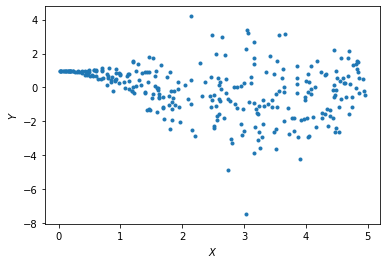

In [239]:
plt.scatter(X,y,marker='.')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

# Standard regression


<div id="data-splitting1"> </div>

## Data splitting



In [240]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

<div id="data-preparation1"> </div>

## Data preparation

In [241]:
# Data preparation (embedding)

from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(4)
Xpoly_train = poly.fit_transform(X_train[:, np.newaxis])
Xpoly_test = poly.fit_transform(X_test[:, np.newaxis])


<div id="fitting1"> </div>

## Fitting

In [242]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(Xpoly_train,y_train)


LinearRegression(fit_intercept=False)

<div id="prediction1"></div>

## Prediction

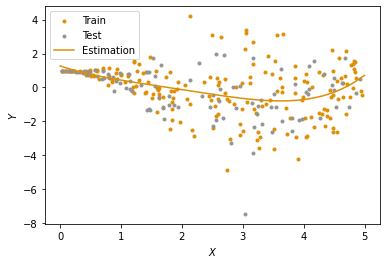

In [243]:
# Visualization
plt.scatter(X_train,y_train,marker='.',color=color_train,label="Train")
plt.scatter(X_test,y_test,marker='.',color=color_test,label="Test")
aux = np.linspace(0,5,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
plt.plot(aux,linear_reg.predict(auxpoly),color=color_train,label="Estimation")
plt.legend()
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [244]:
# Some metrics of performance
y_pred = linear_reg.predict(Xpoly_test)
Rtwo_linear_reg = linear_reg.score(Xpoly_test,y_test)
print("R2 for linear regression (polynomial features): ",Rtwo_linear_reg)
RMSE_linear_reg = np.sqrt(np.mean((y_pred-y_test)**2))
print("RMSE for linear regression (polynomial features): ",RMSE_linear_reg)
RMSE_mean = np.sqrt(np.mean((np.mean(y_train)-y_test)**2))
print("RMSE for mean predictor: ",RMSE_mean)

R2 for linear regression (polynomial features):  0.2135705744567099
RMSE for linear regression (polynomial features):  1.2727821486358577
RMSE for mean predictor:  1.448787378633309


# Quantile regression (QR) 


<div id="fitting2"></div>

## Fitting (QR)

In [245]:
from sklearn.linear_model import QuantileRegressor

from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

beta = 0.1
qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')
qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
qr_down.fit(Xpoly_train, y_train)
qr_up.fit(Xpoly_train, y_train)
qr_med.fit(Xpoly_train, y_train)


QuantileRegressor(alpha=0, solver='highs')

<div id="prediction2"></div>

## Prediction (QR) 

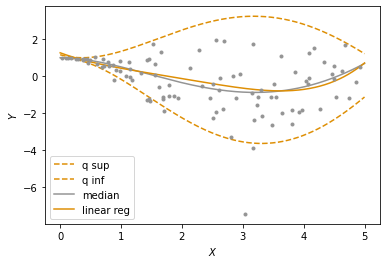

In [246]:
plt.plot(aux,qr_up.predict(auxpoly),'--',color=color_train,label="q sup")
plt.plot(aux,qr_down.predict(auxpoly),'--',color=color_train,label="q inf")
plt.plot(aux,qr_med.predict(auxpoly),'-',color=color_test,label="median")
plt.plot(aux,linear_reg.predict(auxpoly),'-',color=color_train,label="linear reg")
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
#plt.savefig('quantile_reg.pdf', bbox_inches='tight',dpi=300)
plt.show()

## What about coverage? (QR)

In [247]:
y_up_train = qr_up.predict(Xpoly_train)
y_up_test = qr_up.predict(Xpoly_test)
y_down_train = qr_down.predict(Xpoly_train)
y_down_test = qr_down.predict(Xpoly_test)

In [248]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_qr = np.sum((y_down_test<=y_test)*(y_test<=y_up_test))/len(y_test)
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with QR: ",prop_covered_qr)

Theoretical coverage:  0.9
Empirical coverage with QR:  0.9292929292929293


# Split Conformal Prediction (SCP): standard regression

<div id="data-splitting-(SCP)"> </div>

## Data splitting (need of a calibration set) + preparation (SCP)


In [249]:
from sklearn.model_selection import train_test_split

# Data splitting (achtung: overwriting on train data)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=42)
Xpoly_train = poly.fit_transform(X_train[:, np.newaxis])
Xpoly_cal = poly.fit_transform(X_cal[:, np.newaxis])


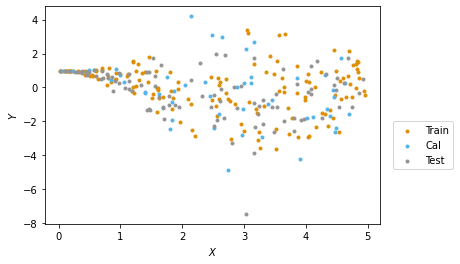

In [250]:
# Visualization

plt.figure()
plt.scatter(X_train,y_train,marker='.',color=color_train,label="Train")
plt.scatter(X_cal,y_cal,marker='.',color=color_cal,label="Cal")
plt.scatter(X_test,y_test,marker='.',color=color_test,label="Test")
plt.legend(loc=(1.04, 0.25))
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

<div id="defining-a-score-(SCP)"> </div>

## Defining a score (SCP)

In [251]:
def my_score(y_pred,y):
    return np.abs(y_pred-y)

<div id="fitting-(SCP)"> </div>

## Fitting (SCP)

In [252]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(Xpoly_train,y_train)

LinearRegression(fit_intercept=False)

<div id="calibration-scores-(SCP)"> </div>

## Calibration scores (SCP)

In [253]:
residuals_cal = my_score(linear_reg.predict(Xpoly_cal),y_cal)
n_cal = len(y_cal)
quantile_scp = np.quantile(residuals_cal,np.ceil((1-beta)*(n_cal+1))/n_cal)

<div id="prediction-(SCP)"> </div>

## Prediction (SCP)

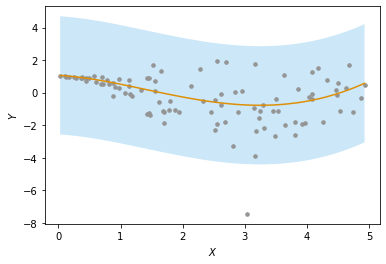

In [254]:
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2, s=50)

y_pred_test = linear_reg.predict(Xpoly_test)
plt.plot(X_test[np.argsort(X_test)],y_pred_test[np.argsort(X_test)],color=color_train)
plt.fill_between(X_test[np.argsort(X_test)],
                 y_pred_test[np.argsort(X_test)]+quantile_scp,
                 y_pred_test[np.argsort(X_test)]-quantile_scp,
                 fc=color_cal,alpha=.3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

<div id="coverage-(SCP)"> </div>

## Coverage (SCP)

In [255]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_scp = np.sum(((y_pred_test-quantile_scp)<=y_test)*(y_test<=(y_pred_test+quantile_scp)))/len(y_test)
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with QR: ",prop_covered_qr)
print("Empirical coverage with SCP: ",prop_covered_scp) ### WORST THAN QR with low n...

Theoretical coverage:  0.9
Empirical coverage with QR:  0.9292929292929293
Empirical coverage with SCP:  0.98989898989899


<div id="Conformalized-Quantile-Regression-(CQR)"> </div>

# Conformalized Quantile Regression (CQR) 



<div id="defining-a-score-(CQR)"> </div>

## Defining a score (CQR)
## USELESS

In [256]:
def my_signed_score(y_pred,y):
    return y_pred-y

<div id="fitting-(CQR)"> </div>

## Fitting (CQR)

In [257]:
from sklearn.linear_model import QuantileRegressor

from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

beta = 0.1
qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')
qr_down.fit(Xpoly_train, y_train)
qr_up.fit(Xpoly_train, y_train)


#qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
#qr_med.fit(Xpoly_train, y_train)

QuantileRegressor(alpha=0, quantile=0.95, solver='highs')

<div id="calibration-scores-(CQR)"> </div>

## Calibration scores (CQR)

In [258]:
y_down_cal = qr_down.predict(Xpoly_cal)
y_up_cal = qr_up.predict(Xpoly_cal)
residuals_cal = np.maximum(y_cal-y_up_cal, y_down_cal-y_cal) #signed scores
n_cal = len(y_cal)
quantile_cqr = np.quantile(residuals_cal,np.ceil((1-beta)*(n_cal+1))/n_cal)

<div id="prediction-(CQR)"> </div>

## Prediction (CQR)

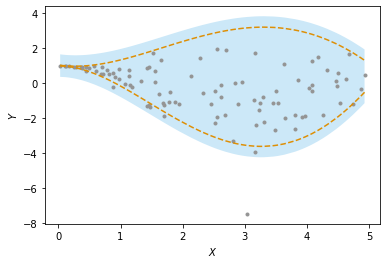

In [259]:
# prediction on test
y_down_test = qr_down.predict(Xpoly_test)
y_up_test = qr_up.predict(Xpoly_test)

# prediction interval
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.plot(X_test[np.argsort(X_test)],
         y_down_test[np.argsort(X_test)],
         '--',
         color=color_train)
plt.plot(X_test[np.argsort(X_test)],
         y_up_test[np.argsort(X_test)],
         '--',
         color=color_train)
plt.fill_between(X_test[np.argsort(X_test)],
                 y_up_test[np.argsort(X_test)]+quantile_cqr,
                 y_down_test[np.argsort(X_test)]-quantile_cqr,
                 fc=color_cal,alpha=.3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
#plt.savefig('CQR_2.pdf', bbox_inches='tight',dpi=300)
plt.show()

<div id="coverage-(CQR)"> </div>

## Coverage (CQR)

In [260]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_cqr = np.sum(((y_down_test-quantile_cqr)<=y_test)*(y_test<=(y_up_test+quantile_cqr)))/len(y_test)
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with QR: ",prop_covered_qr)
print("Empirical coverage with SCP: ",prop_covered_scp) 
print("Empirical coverage with CQR: ",prop_covered_cqr)


Theoretical coverage:  0.9
Empirical coverage with QR:  0.9292929292929293
Empirical coverage with SCP:  0.98989898989899
Empirical coverage with CQR:  0.98989898989899


In [261]:
quantile_cqr

0.6229301162363142

# Opening Jackknife+/CV